In [1]:
import pandas as pd

archivo = "DIST CASTILLO YANEZ PALO GORDO.xlsx"
xls = pd.ExcelFile(archivo)

# Revisar columnas de una hoja de cliente
df_prueba = pd.read_excel(xls, xls.sheet_names[1], header=3)
print(df_prueba.columns.tolist())


['FECHA', 'F-  E-  T-', 'DEUDA Y ABONOS', 'VACIO 1/4', 'VACIO 350', 'VACIO 1.25', 'RETECION']


In [2]:
import pandas as pd

archivo = "DIST CASTILLO YANEZ PALO GORDO.xlsx"
xls = pd.ExcelFile(archivo)

clientes = [hoja for hoja in xls.sheet_names if hoja.lower() != "RESUMEN"]

df_list = []
for hoja in clientes:
    df_temp = pd.read_excel(xls, hoja, header=3)
    # Convertir todos los nombres de columnas a string y normalizar
    df_temp.columns = df_temp.columns.astype(str).str.strip().str.upper()
    
    # Verificar si existen las columnas necesarias
    if any("FECHA" in c for c in df_temp.columns) and any("DEUDA" in c for c in df_temp.columns):
        col_fecha = [c for c in df_temp.columns if "FECHA" in c][0]
        col_deuda = [c for c in df_temp.columns if "DEUDA" in c][0]
        
        df_temp = df_temp[[col_fecha, col_deuda]].copy()
        df_temp["CLIENTE"] = hoja
        df_temp.rename(columns={col_fecha: "FECHA", col_deuda: "DEUDA Y ABONOS"}, inplace=True)
        
        df_list.append(df_temp)
    else:
        print(f"⚠️ La hoja {hoja} no tiene columnas FECHA/DEUDA, se omitió.")

# Unir todas las hojas válidas
df_clientes = pd.concat(df_list, ignore_index=True)

# Convertir FECHA y DEUDA Y ABONOS
df_clientes["FECHA"] = pd.to_datetime(df_clientes["FECHA"], errors="coerce")
df_clientes["DEUDA Y ABONOS"] = pd.to_numeric(
    df_clientes["DEUDA Y ABONOS"].astype(str).str.replace(r'[\$,]', '', regex=True),
    errors="coerce"
)

print(df_clientes.head())

⚠️ La hoja RESUMEN no tiene columnas FECHA/DEUDA, se omitió.
⚠️ La hoja DORIS CAICEDO no tiene columnas FECHA/DEUDA, se omitió.
       FECHA  DEUDA Y ABONOS        CLIENTE
0 2025-06-07           53.29  ABASTO ANTONY
1 2025-06-07           70.60  ABASTO ANTONY
2 2025-06-07           47.60  ABASTO ANTONY
3 2025-06-13         -171.49  ABASTO ANTONY
4 2025-06-13           48.50  ABASTO ANTONY


C:\Users\yessi\AppData\Local\Temp\ipykernel_15880\2382323432.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_clientes = pd.concat(df_list, ignore_index=True)


In [3]:
# Eliminar registros con fecha antes del 1 de junio de 2025
df_clientes = df_clientes[df_clientes["FECHA"] >= pd.to_datetime("2025-06-01")]

print(df_clientes.head())
print(df_clientes["FECHA"].min())  # verificar que la fecha mínima ya es >= 2025-06-01



       FECHA  DEUDA Y ABONOS        CLIENTE
0 2025-06-07           53.29  ABASTO ANTONY
1 2025-06-07           70.60  ABASTO ANTONY
2 2025-06-07           47.60  ABASTO ANTONY
3 2025-06-13         -171.49  ABASTO ANTONY
4 2025-06-13           48.50  ABASTO ANTONY
2025-06-01 00:00:00


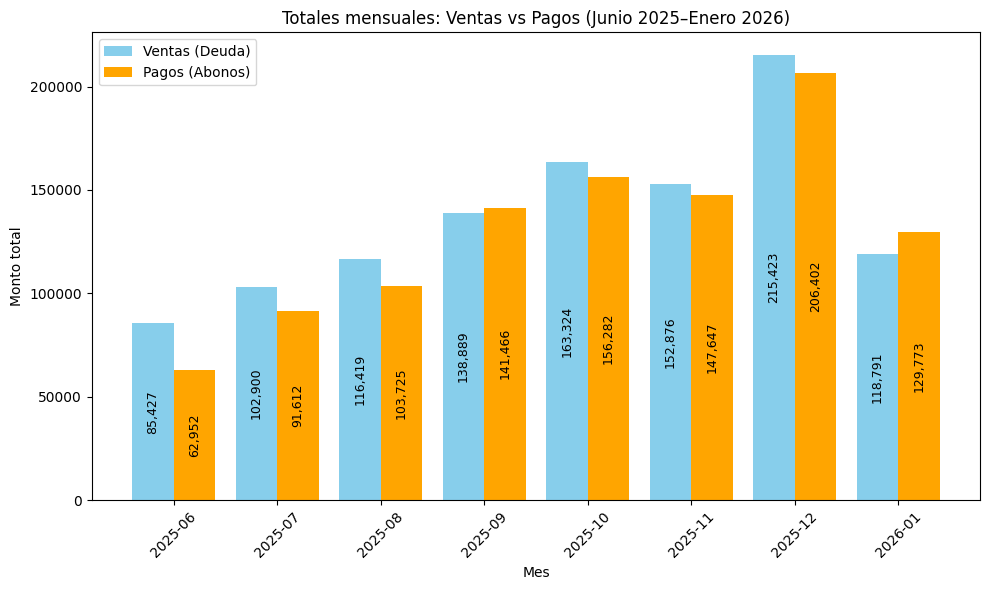

✅ Total de ventas Junio 2025–Enero 2026: 1,094,049.56
✅ Total de pagos Junio 2025–Enero 2026: 1,039,858.99


In [13]:
import matplotlib.pyplot as plt

# --- Separar ventas (positivos) y pagos (negativos) ---
df_clientes["VENTAS"] = df_clientes["DEUDA Y ABONOS"].apply(lambda x: x if x > 0 else 0)
df_clientes["PAGOS"] = df_clientes["DEUDA Y ABONOS"].apply(lambda x: -x if x < 0 else 0)

# Filtrar solo junio a diciembre 2025
df_filtrado = df_clientes[(df_clientes["FECHA"] >= "2025-06-01") & (df_clientes["FECHA"] <= "2026-01-31")]

# Agrupar por mes
ventas_mensuales = df_filtrado.groupby(df_filtrado["FECHA"].dt.to_period("M"))["VENTAS"].sum()
pagos_mensuales = df_filtrado.groupby(df_filtrado["FECHA"].dt.to_period("M"))["PAGOS"].sum()

# --- Gráfico de barras agrupadas con etiquetas dentro ---
fig, ax = plt.subplots(figsize=(10,6))
x = range(len(ventas_mensuales))

bars1 = ax.bar([i-0.2 for i in x], ventas_mensuales, width=0.4, label="Ventas (Deuda)", color="skyblue")
bars2 = ax.bar([i+0.2 for i in x], pagos_mensuales, width=0.4, label="Pagos (Abonos)", color="orange")

# Etiquetas dentro de las barras (vertical y con separador de miles)
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height/2, f"{height:,.0f}", 
            ha="center", va="center", rotation=90, fontsize=9, color="black")

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height/2, f"{height:,.0f}", 
            ha="center", va="center", rotation=90, fontsize=9, color="black")

# Ajustes visuales
ax.set_xticks(x)
ax.set_xticklabels([str(m) for m in ventas_mensuales.index], rotation=45)
ax.set_title("Totales mensuales: Ventas vs Pagos (Junio 2025–Enero 2026)")
ax.set_xlabel("Mes")
ax.set_ylabel("Monto total")
ax.legend()

plt.tight_layout()
plt.show()

# --- Calcular aumento total de ventas y pagos ---
total_ventas = ventas_mensuales.sum()
total_pagos = pagos_mensuales.sum()

print(f"✅ Total de ventas Junio 2025–Enero 2026: {total_ventas:,.2f}")
print(f"✅ Total de pagos Junio 2025–Enero 2026: {total_pagos:,.2f}")

Se observa un pico significativo en las ventas durante el mes de diciembre. Este incremento es una respuesta directa a la temporada alta, impulsada por las festividades navideñas que generan un aumento natural en los niveles de consumo.


📊 Captura de clientes mes a mes (Junio 2025–Enero 2026):
FECHA
2025-06    193
2025-07     41
2025-08     17
2025-09     23
2025-10     19
2025-11     10
2025-12     10
2026-01     13
Freq: M, Name: count, dtype: int64
✅ Total de clientes captados (Junio 2025–Enero 2026): 326

📈 Acumulado de clientes captados mes a mes:


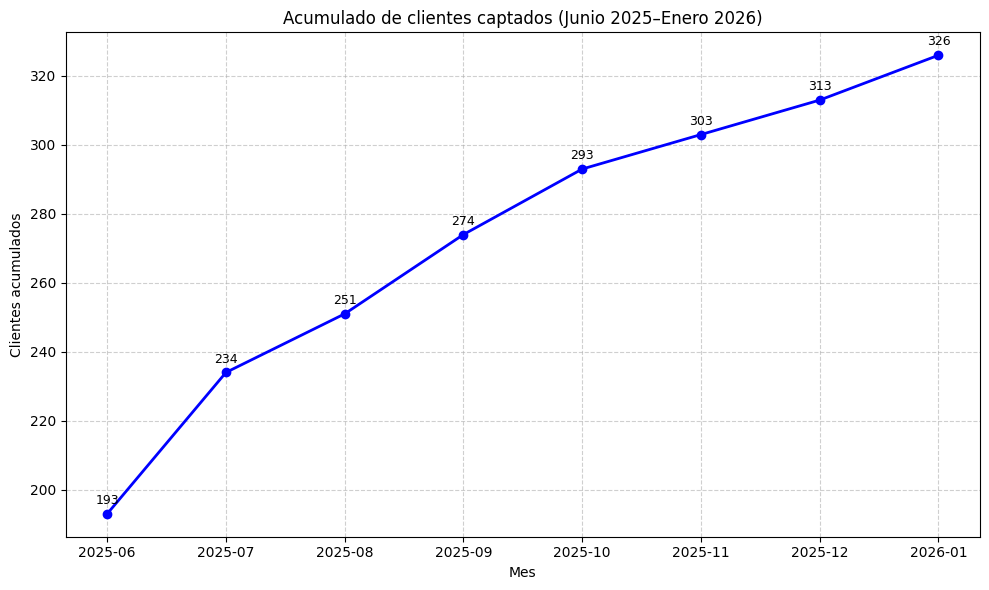

In [ ]:
# Filtrar solo registros desde junio a enero 2026
df_filtrado = df_clientes[(df_clientes["FECHA"] >= "2025-06-01") & (df_clientes["FECHA"] <= "2026-01-31")]

# Obtener la primera fecha en que aparece cada cliente
primer_mes_cliente = df_filtrado.groupby("CLIENTE")["FECHA"].min().dt.to_period("M")

# Contar cuántos clientes fueron captados en cada mes
captura_mensual = primer_mes_cliente.value_counts().sort_index()

print("📊 Captura de clientes mes a mes (Junio 2025–Enero 2026):")
print(captura_mensual)
# Total de clientes captados en el período
total_captados = captura_mensual.sum()
print(f"✅ Total de clientes captados (Junio 2025–Enero 2026): {total_captados:,}")

# --- Gráfico de barras ---

# Acumulado mes a mes
acumulado_mensual = captura_mensual.cumsum()

print("\n📈 Acumulado de clientes captados mes a mes:")


# --- Gráfico de línea ---
plt.figure(figsize=(10,6))
plt.plot(acumulado_mensual.index.astype(str), acumulado_mensual.values, 
         marker="o", color="blue", linewidth=2)

# Etiquetas de valores en cada punto
for i, val in enumerate(acumulado_mensual.values):
    plt.text(i, val+2, f"{val:,}", ha="center", va="bottom", fontsize=9)

# Ajustes visuales
plt.title("Acumulado de clientes captados (Junio 2025–Enero 2026)")
plt.xlabel("Mes")
plt.ylabel("Clientes acumulados")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


este grafico nos muestra que hay un creciomentio en la captacion de nuevos clientes eso es bueno para la empresa

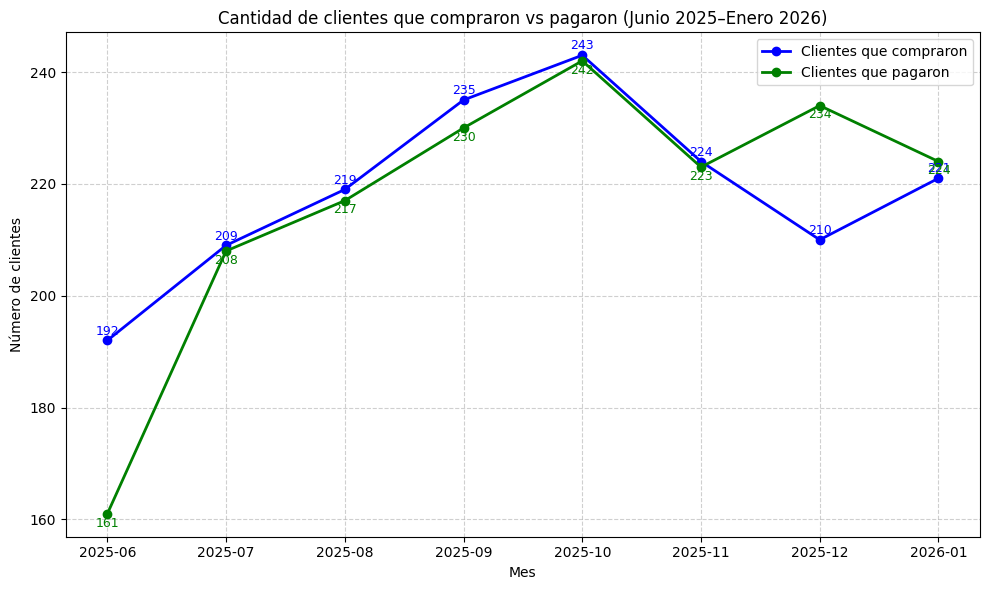

In [ ]:
# Filtrar solo junio a enero 2026
df_filtrado = df_clientes[(df_clientes["FECHA"] >= "2025-06-01") & (df_clientes["FECHA"] <= "2026-01-31")]

# Clientes que compraron (VENTAS > 0)
clientes_compras = df_filtrado[df_filtrado["VENTAS"] > 0].groupby(df_filtrado["FECHA"].dt.to_period("M"))["CLIENTE"].nunique()

# Clientes que pagaron (PAGOS > 0)
clientes_pagos = df_filtrado[df_filtrado["PAGOS"] > 0].groupby(df_filtrado["FECHA"].dt.to_period("M"))["CLIENTE"].nunique()

# --- Gráfico comparativo ---
plt.figure(figsize=(10,6))
plt.plot(clientes_compras.index.astype(str), clientes_compras.values, 
         marker="o", color="blue", linewidth=2, label="Clientes que compraron")
plt.plot(clientes_pagos.index.astype(str), clientes_pagos.values, 
         marker="o", color="green", linewidth=2, label="Clientes que pagaron")

# Etiquetas de valores en cada punto
# Azul (compras) → arriba del círculo
for i, val in enumerate(clientes_compras.values):
    plt.text(i, val+0.5, f"{val:,}", ha="center", va="bottom", fontsize=9, color="blue")

# Naranja (pagos) → debajo del círculo
for i, val in enumerate(clientes_pagos.values):
    plt.text(i, val-0.5, f"{val:,}", ha="center", va="top", fontsize=9, color="green")

# Ajustes visuales
plt.title("Cantidad de clientes que compraron vs pagaron (Junio 2025–Enero 2026)")
plt.xlabel("Mes")
plt.ylabel("Número de clientes")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

el grafico se muestra constante, hay una anormalia en el mes de diciembre esto se debe que se hizo un seguimineto a clientes deudores viejos y que en el mes de diciembre cacelaron.

## Segmentación de clientes (Clustering con K-Means)
Cluster 0 =clientes de bajo volumen , Cluster 1 = clientes VIP , Cluster 2 = clientes regulares

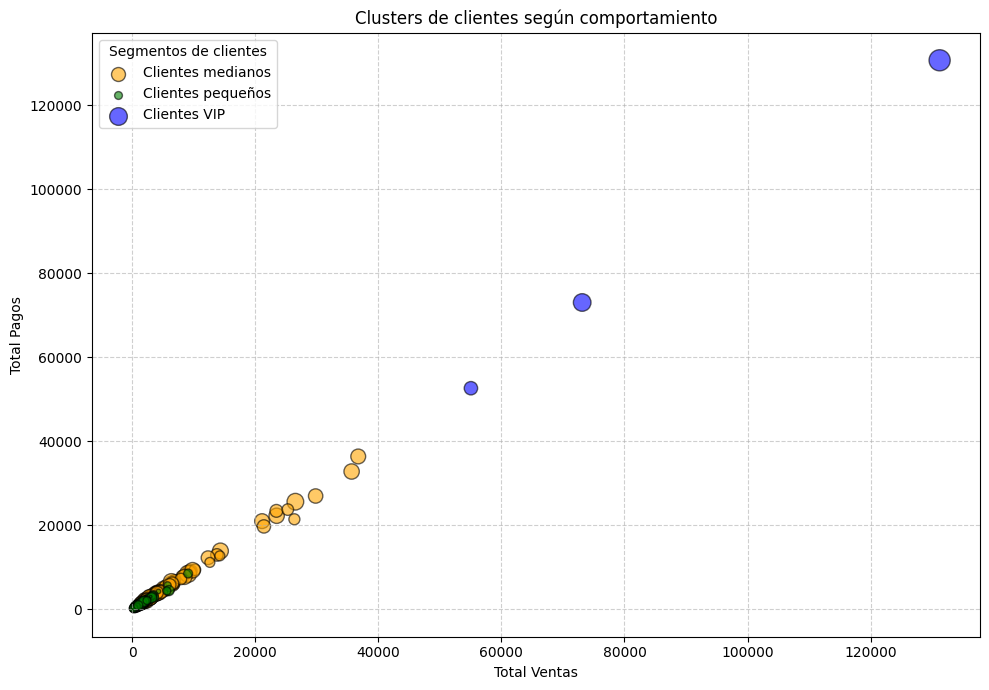


📋 Descripción de clusters:
               VENTAS         PAGOS  FRECUENCIA
CLUSTER                                        
0          877.880182    804.513519   23.848485
1        86467.073333  85462.783333  162.000000
2         7014.558483   6641.551033   90.304348


In [7]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Preparar dataset por cliente ---
df_clientes["VENTAS"] = df_clientes["DEUDA Y ABONOS"].apply(lambda x: x if x > 0 else 0)
df_clientes["PAGOS"] = df_clientes["DEUDA Y ABONOS"].apply(lambda x: -x if x < 0 else 0)

clientes = df_clientes.groupby("CLIENTE").agg({
    "VENTAS": "sum",
    "PAGOS": "sum",
    "FECHA": "count"  # frecuencia de transacciones
}).rename(columns={"FECHA": "FRECUENCIA"})

# --- Normalizar ---
scaler = StandardScaler()
clientes_scaled = scaler.fit_transform(clientes)

# --- K-Means ---
kmeans = KMeans(n_clusters=3, random_state=42)
clientes["CLUSTER"] = kmeans.fit_predict(clientes_scaled)

# --- Visualización mejorada ---
plt.figure(figsize=(10,7))

# Definir colores y etiquetas para cada cluster
colores = {0: "green", 1: "blue", 2: "orange"}
labels = {0: "Clientes pequeños", 1: "Clientes VIP", 2: "Clientes medianos"}

for cluster in clientes["CLUSTER"].unique():
    subset = clientes[clientes["CLUSTER"] == cluster]
    plt.scatter(subset["VENTAS"], subset["PAGOS"], 
                s=subset["FRECUENCIA"], 
                c=colores[cluster], 
                label=labels[cluster], 
                alpha=0.6, edgecolors="k")

plt.xlabel("Total Ventas")
plt.ylabel("Total Pagos")
plt.title("Clusters de clientes según comportamiento")
plt.legend(title="Segmentos de clientes")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- Tabla descriptiva por cluster ---
descripcion_clusters = clientes.groupby("CLUSTER")[["VENTAS","PAGOS","FRECUENCIA"]].mean()
print("\n📋 Descripción de clusters:")
print(descripcion_clusters)



In [8]:
# Top 5 clientes por cluster
for cluster in clientes["CLUSTER"].unique():
    print(f"\nCluster {cluster} - Top 5 clientes")
    print(clientes[clientes["CLUSTER"] == cluster].sort_values("VENTAS", ascending=False).head(5))




Cluster 2 - Top 5 clientes
                           VENTAS     PAGOS  FRECUENCIA  CLUSTER
CLIENTE                                                         
BODEGON DE OLGA        36727.1900  36382.83         114        2
BODEGON LOS NONOS      35653.1800  32799.59         122        2
ZONA FRESS             29802.4728  26967.34         107        2
COMERCIALIZADORA YUDI  26510.5400  25607.92         144        2
TERRAZA BAR GRILL      26349.2900  21429.04          63        2

Cluster 0 - Top 5 clientes
                         VENTAS    PAGOS  FRECUENCIA  CLUSTER
CLIENTE                                                      
BODEGON UNICO           9074.57  8519.12          41        0
BODEGON ENDER GUERRERO  5968.65  4447.31          53        0
BODEGON DE ELIDA        5737.30  5695.57          27        0
COPAS DE PACO           5613.25  4373.45          33        0
AVENTURA INFLABLE       4254.81  4254.81          11        0

Cluster 1 - Top 5 clientes
                        VEN

In [9]:
# Filtrar clientes que compraron en noviembre y diciembre
compraron_nov_dic = df_clientes[
    ((df_clientes["FECHA"].dt.month == 11) | (df_clientes["FECHA"].dt.month == 12)) 
    & (df_clientes["VENTAS"] > 0)
]["CLIENTE"].unique()

# Clientes que NO compraron en noviembre ni diciembre
clientes_sin_compras = clientes[~clientes.index.isin(compraron_nov_dic)]

# Ranking por total de ventas históricas
ranking_sin_compras = clientes_sin_compras.sort_values("VENTAS", ascending=False)

print("📋 Ranking de clientes que NO compraron en noviembre y diciembre:")
print(ranking_sin_compras.head(100))  # Top 100
# Configuración para mostrar todas las filas
pd.set_option("display.max_rows", None)

print(ranking_sin_compras)




📋 Ranking de clientes que NO compraron en noviembre y diciembre:
                                 VENTAS    PAGOS  FRECUENCIA  CLUSTER
CLIENTE                                                              
RICHARD MONSARI                 2995.20  2995.20           3        0
VARIEDADES LUCY                 1984.52  1853.20          39        0
QUESERA DOBLE A                 1451.44  1451.74          16        0
LICORERIA MIS ANGELES           1225.78   825.69          10        0
EL GRONE GOMEZ                  1032.99   948.62          29        0
...                                 ...      ...         ...      ...
DANIEL VERSIONES DURAN            14.50    14.50           2        0
EMPANADA ANA RAMIREZ              13.45    13.45           2        0
FRUTERIA MI PEQUENA AURIYASMIN     9.84     9.84           2        0
EVENTO SENIAT                      0.00     0.00           2        0
EMPRENDIMIENTO RAKEL ROJAS         0.00     6.00           2        0

[76 rows x 4 columns]
  

Proyecto de Segmentación y Análisis de Clientes (Versión Previa)
🎯 Objetivo
Construir un sistema de análisis que permita:
- Monitorear ventas y pagos mensuales.
- Medir la captación de clientes en el tiempo.
- Identificar patrones de comportamiento mediante clustering.
- Generar insights estratégicos para la gestión comercial.

📈 Resultados actuales (Junio 2025–Enero 2026)
Totales
- Ventas acumuladas: 1,094,049.56
- Pagos acumulados: 1,039,858.99
- Clientes captados: 326
## 📈 Captura de clientes (Junio 2025–Enero 2026)
**2025**
- 🟦 Junio: **194** clientes → Acumulado: **194**
- 🟩 Julio: **41** clientes → Acumulado: **235**
- 🟨 Agosto: **17** clientes → Acumulado: **252**
- 🟧 Septiembre: **23** clientes → Acumulado: **275**
- 🟥 Octubre: **19** clientes → Acumulado: **294**
- 🟪 Noviembre: **10** clientes → Acumulado: **304**
- 🟫 Diciembre: **10** clientes → Acumulado: **314**
**2026**
- 🟦 Enero: **12** clientes → Acumulado: **326**



👥 Clusters de clientes
Cluster 2 – Clientes VIP
- Promedio ventas: 6,150
- Promedio pagos: 5,970
- Frecuencia: 83
- Top 5 clientes:
- Bodegón de Olga
- Bodegón Los Nonos
- Zona Fress
- Licorería La Turena
- Terraza Bar Grill
Cluster 1 – Clientes medianos
- Promedio ventas: 81,621
- Promedio pagos: 78,660
- Frecuencia: 146
- Top 3 clientes:
- Licorería Koop
- Licorería Grisyuday
- Torcoroma
Cluster 0 – Clientes pequeños
- Promedio ventas: 800
- Promedio pagos: 738
- Frecuencia: 22
- Top 5 clientes:
- Bodegón Único
- Bodegón de Elida
- Copas de Paco
- Karina B.Gos Bodegón
- Bodegón Ender Guerrero


🚨 Clientes inactivos (sin compras en noviembre y diciembre)
Ejemplos destacados:
- Richard Monsari
- Variedades Lucy
- Quesera Doble A
- El Grone Gómez
- Bodegón Machiri
(64 clientes en total)

🔮 Próximos pasos
- Incorporar más datos históricos para mejorar precisión en clustering.
- Integrar métricas de churn (clientes que dejan de comprar).
- Automatizar dashboards en Power BI / Python.
- Enriquecer el modelo con variables externas (temporada, promociones, etc.).

Este proyecto está en una primera versión funcional que ya permite segmentar clientes y obtener insights claros sobre ventas, pagos y captación. Lo he diseñado para que sea escalable: a medida que se incorporen más datos, el modelo se irá refinando y entregará resultados cada vez más precisos. Es un proyecto vivo que puedo seguir alimentando y mejorando en tiempo real.